<div align="center">  
    <h1>Final Work</h1>  
    <h3>Student: Balerke Kairova</h3>  
</div>

# Task 7: Sentiment Analysis with Transformers

## Objective  
Perform **Sentiment Analysis** using **Transformer models** like **BERT** and compare with traditional **LSTM-based models**.  

## Steps  
- **Sentiment Analysis using BERT**: Fine-tune a **BERT** model on a sentiment analysis dataset (e.g., IMDB reviews).  
- **Comparison with LSTM**: Implement a simple **LSTM-based** sentiment analysis model and compare its performance to **BERT**.  
- **Evaluate**: Use **accuracy, F1-score, and confusion matrix** for evaluation.  

## Expected Outputs  
- Performance comparison report between **BERT and LSTM**.  
- Code snippets for **fine-tuning BERT** and **training an LSTM**.  
- A conclusion on which model performs better for sentiment analysis.

In [27]:
# Environment and Logging
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['KERAS_BACKEND'] = 'tensorflow'
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from datasets import load_dataset

In [11]:
# Load IMDB dataset
ds = load_dataset("imdb")

# Convert train and test splits to DataFrames
train_df = pd.DataFrame(ds['train'])
test_df = pd.DataFrame(ds['test'])

In [12]:
print("*"*30 + " TRAIN DATAFRAME " + "*"*30)
display(train_df.head())
print()
print("*"*30 + " DEV DATAFRAME " + "*"*30)
display(test_df.head())
print()

****************************** TRAIN DATAFRAME ******************************


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0



****************************** DEV DATAFRAME ******************************


,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


In [13]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/

In [14]:
# Define stopwords and lemmatizer
english_stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [15]:
# Function to clean the text
def clean_text(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'\W', ' ', text)
    # Remove digits
    text = re.sub(r'\d', ' ', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stop words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in english_stopwords])
    return text

In [16]:
# Apply the clean_text function to the text column
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

In [17]:
# Convert all values to strings, and fill NaNs with an empty string
train_df['clean_text'] = train_df['clean_text'].fillna('').astype(str)
test_df['clean_text'] = test_df['clean_text'].fillna('').astype(str)

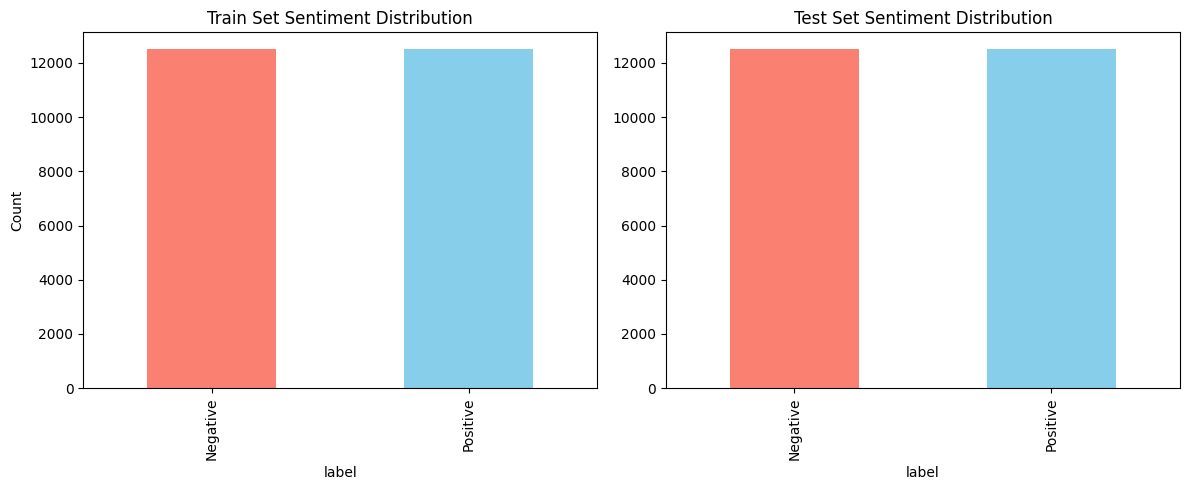

In [23]:
# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot training set label distribution
train_df['label'].value_counts().plot(kind='bar', ax=axes[0], color=['salmon', 'skyblue'])
axes[0].set_title('Train Set Sentiment Distribution')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Negative', 'Positive'])
axes[0].set_ylabel("Count")

# Plot test set label distribution
test_df['label'].value_counts().plot(kind='bar', ax=axes[1], color=['salmon', 'skyblue'])
axes[1].set_title('Test Set Sentiment Distribution')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Negative', 'Positive'])

# Show plot
plt.tight_layout()
plt.show()

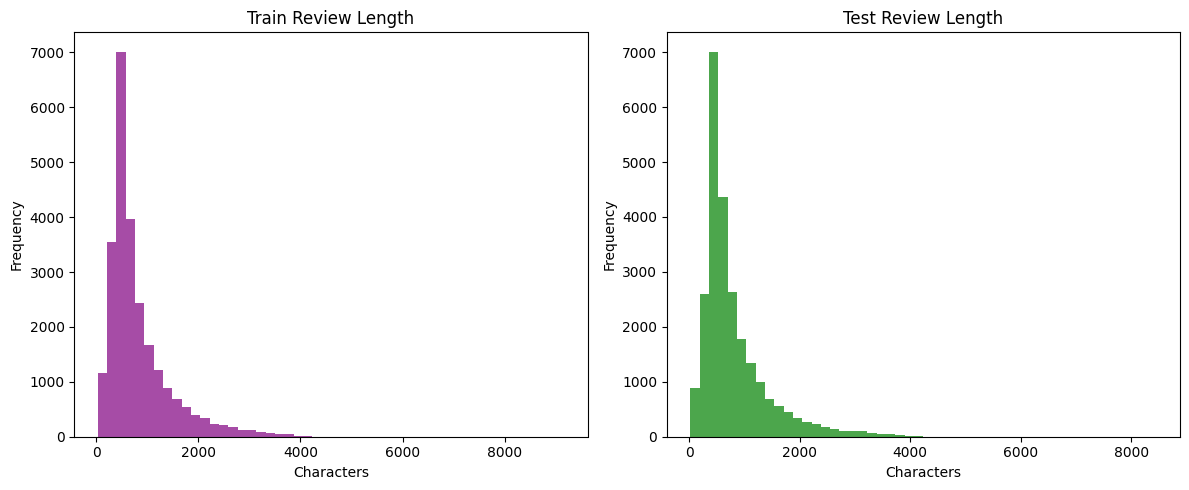

In [30]:
# Add text length columns
train_df['text_length'] = train_df['clean_text'].apply(len)
test_df['text_length'] = test_df['clean_text'].apply(len)

# Plot side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train
train_df['text_length'].plot(kind='hist', bins=50, ax=axes[0], color='purple', alpha=0.7)
axes[0].set_title("Train Review Length")
axes[0].set_xlabel("Characters")

# Test
test_df['text_length'].plot(kind='hist', bins=50, ax=axes[1], color='green', alpha=0.7)
axes[1].set_title("Test Review Length")
axes[1].set_xlabel("Characters")

plt.tight_layout()
plt.show()

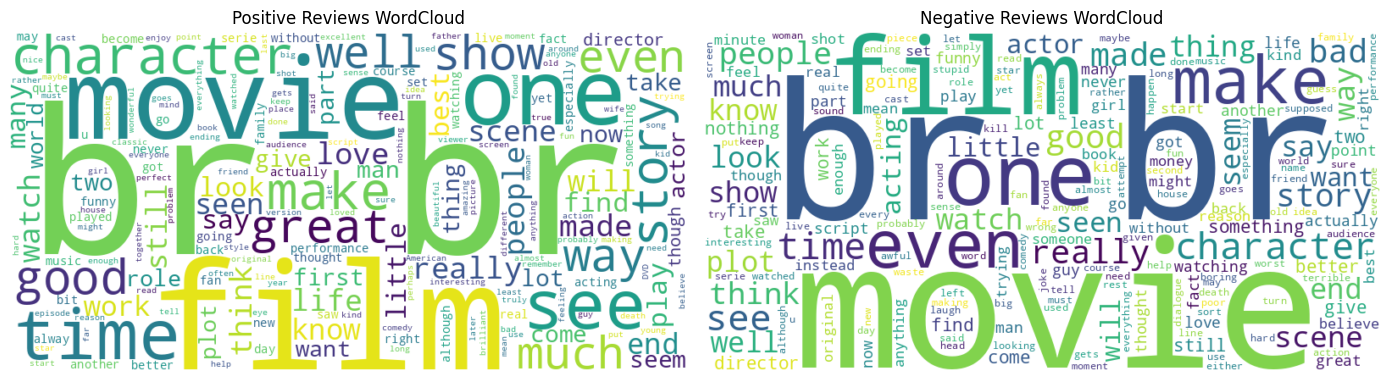

In [26]:
from wordcloud import WordCloud

# Combine all reviews into one string
text_pos = " ".join(train_df[train_df['label'] == 1]['text'].tolist())
text_neg = " ".join(train_df[train_df['label'] == 0]['text'].tolist())

# Generate word clouds
wc_pos = WordCloud(width=800, height=400, background_color='white').generate(text_pos)
wc_neg = WordCloud(width=800, height=400, background_color='white').generate(text_neg)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(wc_pos, interpolation='bilinear')
axes[0].set_title("Positive Reviews WordCloud")
axes[0].axis("off")

axes[1].imshow(wc_neg, interpolation='bilinear')
axes[1].set_title("Negative Reviews WordCloud")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# LSTM

In [36]:
# Parameters for tokenization and padding
max_words = 10000  # Maximum number of words to consider
max_len = 2500      # Maximum length of sequences

# Tokenizer setup and fitting on the training set
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])  # Fit only on training data

# Convert texts to sequences
X_train_sequences = tokenizer.texts_to_sequences(train_df['clean_text'])
X_test_sequences = tokenizer.texts_to_sequences(test_df['clean_text'])

# Padding sequences to ensure uniform input shape
X_train_nn = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_nn = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

# Label encoding for the target variable
label_encoder = LabelEncoder()
y_train_nn = label_encoder.fit_transform(train_df['label'])
y_test_nn = label_encoder.transform(test_df['label'])

In [37]:
# Hyperparameters
embedding_dim = 64

# Build the model 
model_nn = Sequential([
    InputLayer(input_shape=(X_train_nn.shape[1],)),
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=0.003)
model_nn.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model_nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 2500, 64)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 2500, 128)           │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 749,377 (2.86 MB)

 Trainable params: 749,377 (2.86 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Train the model with validation data
history = model_nn.fit(
    X_train_nn, y_train_nn,  # Training data
    validation_data=(X_test_nn, y_test_nn),  # Validation data
    epochs=5,
    batch_size=64
)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 149s 365ms/step - accuracy: 0.7214 - loss: 0.5352 - val_accuracy: 0.7961 - val_loss: 0.5016
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 144s 369ms/step - accuracy: 0.8606 - loss: 0.3559 - val_accuracy: 0.8451 - val_loss: 0.4326
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 144s 369ms/step - accuracy: 0.8833 - loss: 0.2956 - val_accuracy: 0.8346 - val_loss: 0.4327
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 144s 369ms/step - accuracy: 0.9129 - loss: 0.2325 - val_accuracy: 0.8587 - val_loss: 0.3640
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 144s 369ms/step - accuracy: 0.9492 - loss: 0.1482 - val_accuracy: 0.8494 - val_loss: 0.4139


In [42]:
# Get predictions
y_test_probs = model_nn.predict(X_test_nn)

782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step


In [43]:
y_test_pred_lstm = (y_test_probs > 0.5).astype(int)

# Accuracy
acc = accuracy_score(test_df['label'], y_test_pred_lstm)

# F1-score (binary classification → average='binary')
f1 = f1_score(test_df['label'], y_test_pred_lstm, average='binary')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8494
F1 Score: 0.8545


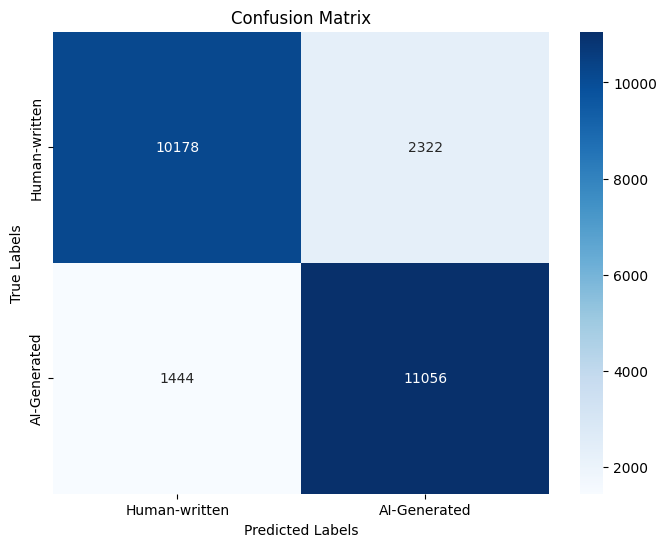

In [45]:
# Confusion matrix
conf_matrix = confusion_matrix(test_df['label'], y_test_pred_lstm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human-written', 'AI-Generated'], yticklabels=['Human-written', 'AI-Generated'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# BERT

In [61]:
# Hyperparameters
SEQ_LENGTH = 512
BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 5e-4

# Load BERT tokenizer/preprocessor
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_base_en_uncased",
    sequence_length=SEQ_LENGTH,
)

# Load pretrained BERT classifier
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_base_en_uncased",
    num_classes=1,  # Binary classification (0 or 1)
    activation="sigmoid",
    preprocessor=preprocessor,
)

# Freeze all layers first
for layer in classifier.backbone.layers:
    layer.trainable = False

# Fine-tune only the last two layers
for layer in classifier.backbone.layers[-2:]:
    layer.trainable = True

# Compile the model
classifier.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy'],
)

# Model summary
classifier.summary()

Preprocessor: "bert_text_classifier_preprocessor_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │     109,482,240 │ padding_mask[0][0],        │
│                               │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 1)                 │             769 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 109,483,009 (417.64 MB)

 Trainable params: 7,679,233 (29.29 MB)

 Non-trainable params: 101,803,776 (388.35 MB)

In [62]:
# Data preparation: Convert Pandas dataframes to tf.data.Dataset
def create_dataset(texts, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    dataset = dataset.shuffle(len(texts)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_df['clean_text'], train_df['label'], BATCH_SIZE)
test_dataset = create_dataset(test_df['clean_text'], test_df['label'], BATCH_SIZE)

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

# Fit the model
classifier.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
)

Epoch 1/2
391/391 ━━━━━━━━━━━━━━━━━━━━ 2071s 5s/step - accuracy: 0.7939 - loss: 0.4365 - val_accuracy: 0.8659 - val_loss: 0.3105
Epoch 2/2
391/391 ━━━━━━━━━━━━━━━━━━━━ 1958s 5s/step - accuracy: 0.8555 - loss: 0.3395 - val_accuracy: 0.8666 - val_loss: 0.3078


In [63]:
# Get predictions
y_test_probs = classifier.predict(test_df['clean_text'])

782/782 ━━━━━━━━━━━━━━━━━━━━ 894s 1s/step


In [64]:
y_test_pred_bert = (y_test_probs > 0.5).astype(int)

# Accuracy
acc_bert = accuracy_score(test_df['label'], y_test_pred_bert)

# F1-score (binary classification → average='binary')
f1_bert = f1_score(test_df['label'], y_test_pred_bert, average='macro')

print(f"Accuracy: {acc_bert:.4f}")
print(f"F1 Score: {f1_bert:.4f}")

Accuracy: 0.8666
F1 Score: 0.8666


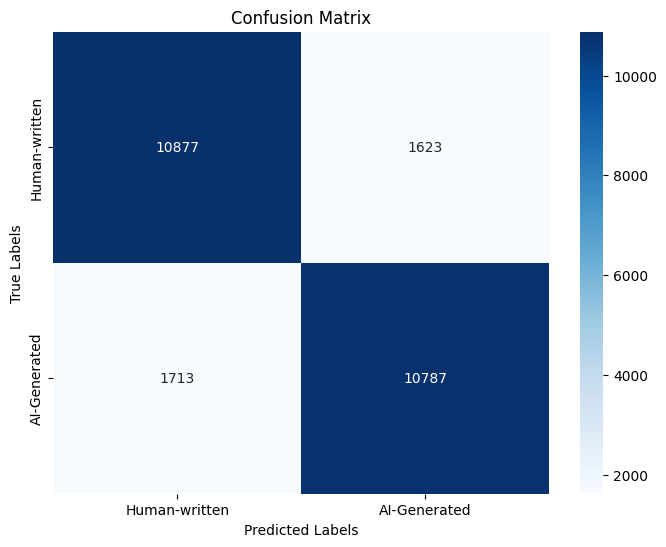

In [65]:
# Confusion matrix
conf_matrix = confusion_matrix(test_df['label'], y_test_pred_bert)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human-written', 'AI-Generated'], yticklabels=['Human-written', 'AI-Generated'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()